In [1]:
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, AveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.activations import relu, sigmoid, softmax
from tensorflow.keras import backend as K
import sys
import numpy as np
import tensorflow as tf

from ctypes import CDLL, Structure, c_uint, c_float, c_ubyte, POINTER, pointer

import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib notebook

# Tensor Structure Wrapper

## unpackIndex

Unpax a tuple into a 4-tuple and fills all missing values with the default. 

**Input Parameters**
* i -- The desired shape
* default -- The default value

**Output Parameters**
* The desired shape

## Tensor

The Tensor wrapper class. 

### __init__

The constructor. Either creates a tensor from a numpy array or a shape. 

**Input Parameters**
* i -- The input (either a shape tuple or a numpy array)

### __del__

The destructor. Frees the internally allocated memory. 

### __getitem__

Array getter. 

**Input Parameters:**
* i -- The index tuple

**Output Parameters**
* The requested element

### __setitem__

Array setter. 

**Input Parameters:**
* i -- The index tuple

### shape

Returns the shape tuple. 

**Output Parameters**
* The shape tuple

### reshape

Reshapes the Tensor. 

**Input Parameters:**
* i -- The new shape tuple

## numpy

Converts the tensor to a numpy array

**Output Parameters**
* The numpy array

In [2]:
lib = CDLL("./libdeep_cyber.so")

def unpackIndex(i, default):
    a = b = c = d = default
    if type(i) == int:
        d = i
    elif len(i) == 1:
        d = i[0]
    elif len(i) == 2:
        c = i[0]
        d = i[1]
    elif len(i) == 3:
        b = i[0]
        c = i[1]
        d = i[2]
    else:
        a = i[0]
        b = i[1]
        c = i[2]
        d = i[3]
    return (a, b, c, d)

class Tensor(Structure):
    _fields_ = [("a", c_uint),
               ("b", c_uint),
               ("c", c_uint),
               ("d", c_uint),
               ("data", POINTER(c_float))]

    def __init__(self, i):
        if type(i) == tuple:
            (a, b, c, d) = unpackIndex(i, 1)
            lib.create_tensor.argtypes = [c_uint, c_uint, c_uint, c_uint]
            lib.create_tensor.restype = Tensor
            t = lib.create_tensor(a, b, c, d)
            self.a = t.a
            self.b = t.b
            self.c = t.c
            self.d = t.d
            self.data = t.data
            t.data = None
        elif type(i) == np.ndarray:
            # create new tensor
            (a, b, c, d) = unpackIndex(i.shape, 1)
            lib.create_tensor.argtypes = [c_uint, c_uint, c_uint, c_uint]
            lib.create_tensor.restype = Tensor
            
            # copy data from numpy array
            t = lib.create_tensor(1, 1, 1, a*b*c*d)
            i = i.flatten()
            for x in range(t.d):
                t[x] = float(i[x])
                
            # move data 
            self.data = t.data
            t.data = None
            self.a = a
            self.b = b
            self.c = c
            self.d = d
        else:
            raise("Illegal input type!")

    def __del__(self):
        lib.free_tensor.argtypes = [Tensor]
        lib.free_tensor(self)

    def __getitem__(self, i):
        (a, b, c, d) = unpackIndex(i, 0)
        lib.at.argtypes = [POINTER(Tensor), c_uint, c_uint, c_uint, c_uint]
        lib.at.restype = POINTER(c_float)
        return lib.at(pointer(self), a, b, c, d)[0]

    def __setitem__(self, i, v):
        (a, b, c, d) = unpackIndex(i, 0)
        lib.at.argtypes = [POINTER(Tensor), c_uint, c_uint, c_uint, c_uint]
        lib.at.restype = POINTER(c_float)
        lib.at(pointer(self), a, b, c, d)[0] = float(v)

    @property
    def shape(self):
        if self.a != 1 and self.b != 1 and self.c != 1 and self.d != 1:
            return (self.a, self.b, self.c, self.d)
        elif self.b != 1 and self.c != 1 and self.d != 1:
            return (self.b, self.c, self.d)
        elif self.c != 1 and self.d != 1:
            return (self.c, self.d)
        else:
            return (self.d, )
        
    def reshape(self, i):
        (self.a, self.b, self.c, self.d) = unpackIndex(i, 1)
        
    def numpy(self):
        t = np.zeros((self.a, self.b, self.c, self.d))
        for ai in range(self.a):
            for bi in range(self.b):
                for ci in range(self.c):
                    for di in range(self.d):
                        t[ai, bi, ci, di] = self[ai, bi, ci, di]
        return t

# Helper Functions

## create_random_input

Creates a random input vector in the desired shape. The numbers are between 0 and size / 128.

**Input Parameters**
* shape -- The desired shape
* divider -- The divider to scale the output by

**Output Parameters**
* The desired tensor

## ref_conf2d

The reference Conv2D implementation from TensorFlow. 

**Input Parameters**
* X -- The input tensor
* w -- The weights
* b -- The bias
* kernel_size -- The kernel size (kernel_rows, kernel_cols)
* strides -- The strides (stride_rows, stride_cols)
* padding -- "valid" for no padding, "same" for zero padding
* groups -- The number of desired groups

**Output Parameters**
* The result tensor of the convolution

## check_conv2d

Checks an input function with the given parameters against the reference implementation of TensorFlow. 

**Input Parameters**
* fn -- The function to compare to
* shape -- The shape to test the function with
* kernel_size -- The kernel size (kernel_rows, kernel_cols) 
* filters -- The number of filters to use
* strides -- The strides (stride_rows, stride_cols)
* padding -- "valid" for no padding, "same" for zero padding
* groups -- The number of desired groups

**Output Parameters**
* True if the function produces the same output as the reference, False otherwise

## Important Note

Due to floating point inaccuracies (hopefully), the results are not equal but close instead. 

In [3]:
def create_random_input(shape, divider=128.0):
    num_elements = np.prod(shape)
    return np.random.randint(0, num_elements, num_elements).astype(np.float32).reshape(shape) / divider

def ref_conv2d(X, w, b, kernel_size, strides, padding, groups):
    return Conv2D(input_shape=X.shape, weights=[w, b], kernel_size=kernel_size, filters=w.shape[3], strides=strides, padding=padding, groups=groups)(X).numpy()
    
def check_conv2d(fn, shape, kernel_size, filters, strides, padding, groups=1):
    np.random.seed(3)
    X = create_random_input(shape)
    w = create_random_input((kernel_size[0], kernel_size[1], shape[3], filters))
    b = create_random_input((filters,))
    
    ref = ref_conv2d(X, w, b, kernel_size, strides, padding, groups)
    res = fn(X, w, b, kernel_size, strides, padding, groups)
    
    #diff = (ref - res).reshape(res.shape[1], res.shape[2],)
    diff = ref - res
    
    print(diff.shape)
    
    plt.figure()
    plt.imshow(diff[0, 0:-1, 0:-1, 0])
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.imshow(diff[0, 0:-1, 0:-1, 1])
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.imshow(diff[1, 0:-1, 0:-1, 0])
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.imshow(diff[1, 0:-1, 0:-1, 1])
    plt.colorbar()
    plt.show()
    
    return np.allclose(res, ref)

# Conv2D Implementation

The actual Conv2D implementation. This function has the same input and output parameters as the ref_conv2d function. 

(2, 126, 126, 2)


<IPython.core.display.Javascript object>


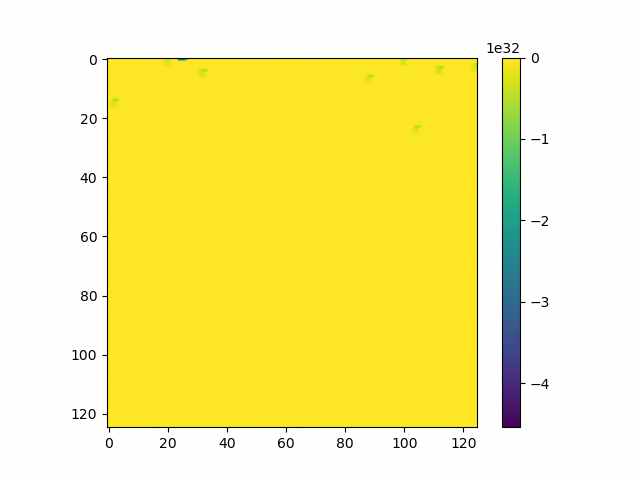

<IPython.core.display.Javascript object>


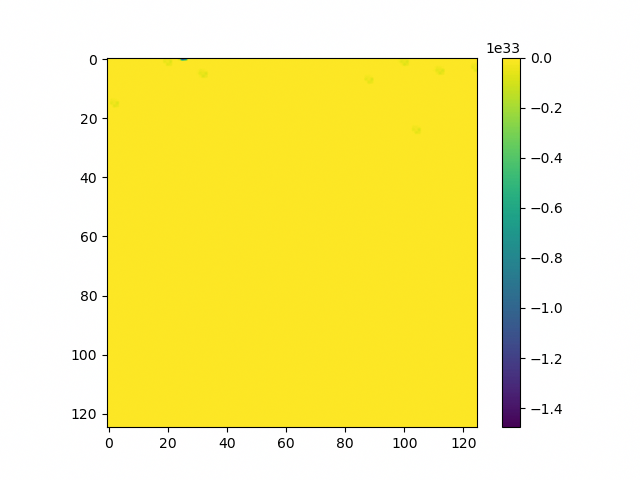

<IPython.core.display.Javascript object>


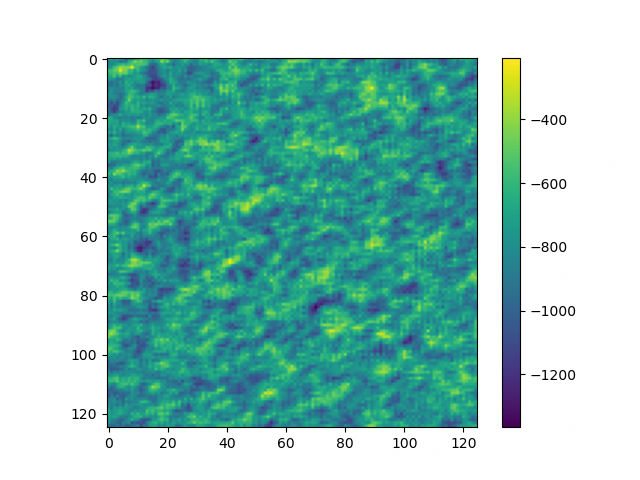

<IPython.core.display.Javascript object>


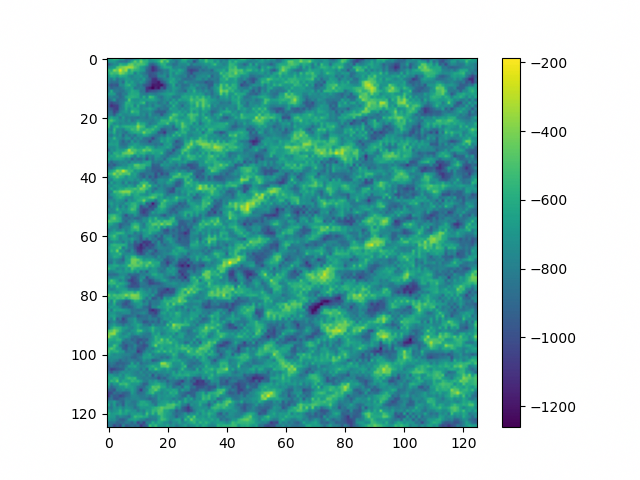

False


In [4]:
def res_conv2d(X, w, b, kernel_size, strides, padding, groups):
    X = Tensor(X)
    w = Tensor(w)
    b = Tensor(b)
    lib.conv2d.argtypes = [Tensor, Tensor, Tensor, c_ushort, c_ushort, c_ushort, c_ushort]
    lib.conv2d.restype = Tensor
    return lib.conv2d(X, w, b, int(strides[0]), int(strides[1]), int(padding == "same"), int(groups)).numpy()
    
print(check_conv2d(res_conv2d, (2, 128, 128, 2), (3, 3), 2, (1, 1), "valid"))
#print(check_conv2d(res_conv2d, (2, 128, 128, 4), (3, 3), 5, (3, 3), "same"))
#print(check_conv2d(res_conv2d, (1, 3, 3, 1), (3, 3), 1, (1, 1), "valid"))
#print(check_conv2d(res_conv2d, (1, 4, 4, 1), (1, 1), 1, (1, 1), "valid"))

# More Helper Functions

## ref_dense

The reference Dense implementation from TensorFlow. 

**Input Parameters**
* X -- The input tensor
* w -- The weights
* b -- The bias

**Output Parameters**
* The result tensor of the convolution

## check_dense

Checks an input function with the given parameters against the reference implementation of TensorFlow. 

**Input Parameters**
* fn -- The function to compare to
* units -- The dimension of the output
* shape -- The shape to test the function with

**Output Parameters**
* True if the function produces the same output as the reference, False otherwise

## Important Note

Due to floating point inaccuracies (hopefully), the results are not equal but close instead. 

In [4]:
def ref_dense(X, w, b):
    return Dense(w.shape[1], input_shape=X.shape, weights=[w, b])(X).numpy()
    
def check_dense(fn, units, shape):
    np.random.seed(3)
    shape = np.array(shape)
    size = np.prod(shape[1:])
    
    X = create_random_input((shape[0], size))
    w = create_random_input((size, units))
    b = create_random_input((units))
    
    ref = ref_dense(X, w, b)
    res = fn(X, w, b)
    
    #return (res == ref).all()
    return np.allclose(res, ref)

# Dense Layer Implementation

The actual dense layer implementation. This function has the same input and output parameters as the ref_dense function. 

In [5]:
def res_dense(X, w, b):
    X = Tensor(X)
    w = Tensor(w)
    b = Tensor(b)
    lib.dense.argtypes = [Tensor, Tensor, Tensor]
    lib.dense.restype = Tensor
    return lib.dense(X, w, b).numpy()

print(check_dense(res_dense, 3, (5, 256)))

False
